### Importing libraries

In [1]:
import numpy as np 
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Dataset creation

In [2]:
min_len = 2
max_len = 10
num_samples = 5000

# creating empty lists
x = []
y = []

for i in range(num_samples):
    sum = 0
    # Taking a random number between 2 and 10
    length = np.random.randint(min_len, max_len)
    sequence = np.zeros((length, 2))
    # appending first dimension of sequence with random numbers between 0 and 1
    sequence[:, 0] = np.random.rand(length)
    # randomly choosing two indices and replacing with 1
    idx = np.random.choice(length, size=2, replace=False)
    sequence[idx, 1] = 1
    sum = np.sum(sequence[idx,0])
    # appending input sequence and targets
    x.append(sequence)
    y.append(sum)

dataset = list(zip(x,y))
x = np.array(x,dtype=object)
y = np.array(y)

print(f'shape of x is {x.shape}')
print(f'shape of y is {y.shape}')

shape of x is (5000,)
shape of y is (5000,)


### dataset creation for testing model

In [3]:
min_len = 2
max_len = 20
num_samples = 500

x_test = []
y_test = []

for i in range(num_samples):
    sum = 0
    # Taking a random number between 2 and 20
    length = np.random.randint(min_len, max_len)
    sequence = np.zeros((length, 2))
    # appending first dimension of sequence with random numbers between 0 and 1
    sequence[:, 0] = np.random.rand(length)
    # randomly choosing two indices and replacing with 1
    idx = np.random.choice(length, size=2, replace=False)
    sequence[idx, 1] = 1
    sum = np.sum(sequence[idx,0])
    # appending input sequence and targets
    x_test.append(sequence)
    y_test.append(sum)

dataset_test = list(zip(x_test,y_test))

### Baseline


In [4]:
# defining base class
class baseline(nn.Module):
    def forward(self):
        return torch.tensor(1.0)
    
# defining model and loss funciton
modelbase = baseline()
criterian = nn.MSELoss()
num_epochs = 10
baseline_loss = []

with torch.no_grad():
    for epoch in range(num_epochs):
        test_loss = 0.0
        for (inputs, targets) in dataset:
            outputs = modelbase()
            loss = criterian(outputs, torch.tensor(targets,dtype=torch.float32))
            test_loss += loss.item()
            
        test_loss /= len(dataset) 
        baseline_loss.append(test_loss)
    print(f'Base line Test Loss: {test_loss}')

Base line Test Loss: 0.16159694697402036


### Elmon network

In [5]:
class ElmanNet(nn.Module):
    def __init__(self):
        super().__init__()

        # randomly defining weights of parameters
        self.u = nn.Parameter(torch.rand((5,2)),requires_grad=True)
        self.w = nn.Parameter(torch.rand((5,5)),requires_grad=True)
        self.v = nn.Parameter(torch.rand((1,5)),requires_grad=True)
        self.h = torch.zeros((5,1))
        self.bx = nn.Parameter(torch.rand((5,1)),requires_grad=True)
        self.bh = nn.Parameter(torch.rand((1,1)),requires_grad=True)

    # defining forward pass
    def forward(self,X):
        copyh = self.h
        for x in X:
            copyh = torch.tanh(torch.matmul(self.w,copyh) + torch.matmul(self.u,torch.reshape(x,(2,1))) + self.bx )
        y = torch.matmul(self.v,copyh) + self.bh

        return y 


In [6]:
# defining model and optimizer
model_Elman = ElmanNet()
optimizer_Elman = optim.Adam(model_Elman.parameters(),lr=0.001)
model_Elman.train()

# training Elman network
losses_elman = []
for epoch in range(num_epochs):
    tot_loss = 0.0
    for (inputs, targets) in dataset:
        optimizer_Elman.zero_grad()

        outputs = model_Elman(torch.tensor(inputs,dtype=torch.float32))
        targets = torch.tensor(targets,dtype=torch.float32)
        loss = criterian(outputs, targets)

        loss.backward()
        optimizer_Elman.step()

        tot_loss += loss.item()

    losses_elman.append(tot_loss/len(dataset))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {tot_loss/len(dataset)}')

/home/bhanu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.28422196201411914
Epoch [2/10], Loss: 0.09677966344681348
Epoch [3/10], Loss: 0.08851017968619455
Epoch [4/10], Loss: 0.08213757122370242
Epoch [5/10], Loss: 0.06103559317826264
Epoch [6/10], Loss: 0.028254586845335918
Epoch [7/10], Loss: 0.018656964590677616
Epoch [8/10], Loss: 0.013777806264874511
Epoch [9/10], Loss: 0.010589630416568213
Epoch [10/10], Loss: 0.008379428756114839


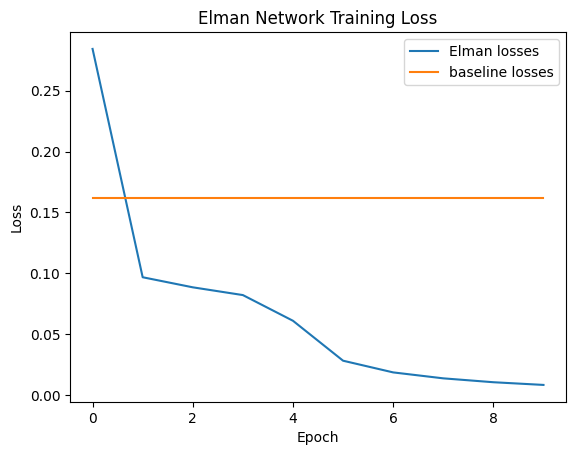

In [7]:
# plotting loss vs epoch graph
plt.plot(losses_elman,label="Elman losses")
plt.plot(baseline_loss,label="baseline losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Elman Network Training Loss')
plt.show()

In [8]:
model_Elman.eval()

# Testing elman network and comparing loss with baseline loss
with torch.no_grad():
    test_loss=0.0
    for (inputs, targets) in dataset_test:
        inputs = torch.tensor(inputs,dtype=torch.float32)
        targets = torch.tensor(targets,dtype=torch.float32)
        predicted_sum = model_Elman(inputs)
        loss = criterian(predicted_sum,targets)
        test_loss += loss.item()
        
    test_loss /= len(dataset_test) 
    print(f'Elman Test Loss: {test_loss}')


with torch.no_grad():
    test_loss = 0.0
    for (inputs, targets) in dataset_test:
        outputs = modelbase()
        loss = criterian(outputs, torch.tensor(targets,dtype=torch.float32))
        test_loss += loss.item()
        
    test_loss /= len(dataset_test) 
    print(f'Base line Test Loss: {test_loss}')

Elman Test Loss: 0.03448502896181637
Base line Test Loss: 0.16553435947762457


#### LSTM

In [9]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        # defining randomly initialized weights for input gate
        self.whi = nn.Parameter(torch.rand((5,5)),requires_grad=True)
        self.wxi = nn.Parameter(torch.rand((5,2)),requires_grad=True)
        self.bi = nn.Parameter(torch.rand((5,1)),requires_grad = True)

        # defining randomly initialized weights for forgot gate
        self.whf = nn.Parameter(torch.rand((5,5)),requires_grad=True)
        self.wxf = nn.Parameter(torch.rand((5,2)),requires_grad=True)
        self.bf = nn.Parameter(torch.rand((5,1)),requires_grad = True)

        # defining randomly initialized weights for cell state
        self.whg = nn.Parameter(torch.rand((5,5)),requires_grad=True)
        self.wxg = nn.Parameter(torch.rand((5,2)),requires_grad=True)
        self.bg = nn.Parameter(torch.rand((5,1)),requires_grad = True)

        # defining randomly initialized weights for output gate
        self.who = nn.Parameter(torch.rand((5,5)),requires_grad=True)
        self.wxo = nn.Parameter(torch.rand((5,2)),requires_grad=True)
        self.bo = nn.Parameter(torch.rand((5,1)),requires_grad = True)

        self.v = torch.rand((1,5))
        self.b = torch.rand((1,5))
        self.h = torch.zeros(5)
        self.c = torch.zeros(5)

    # defining forward pass
    def forward(self,X):
        copyc = self.c
        copyh = self.h
        for i in range(len(X)):
            input_gate = torch.sigmoid(torch.matmul(self.whi,copyh)+torch.matmul(self.wxi,X[i])+self.bi)
            forgot_gate = torch.sigmoid(torch.matmul(self.whf,copyh)+torch.matmul(self.wxf,X[i])+self.bf)
            state = torch.tanh(torch.matmul(self.whg,copyh)+torch.matmul(self.wxg,X[i])+self.bg)
            output_gate = torch.sigmoid(torch.matmul(self.who,copyh)+torch.matmul(self.wxo,X[i])+self.bo)

            copyc = forgot_gate*copyc + input_gate*state
            copyh = output_gate*torch.tanh(copyc)
        
        y = torch.matmul(self.v,copyh) + self.b

        return y

In [10]:
# defining model and optimizer
model_LSTM = LSTM()
optimizer_LSTM = optim.Adam(model_LSTM.parameters(),lr=0.01)
model_LSTM.train()

# training LSTM 
losses_lstm = []
for epoch in range(num_epochs):
    tot_loss = 0.0
    for (inputs, targets) in dataset:
        optimizer_LSTM.zero_grad()

        outputs = model_LSTM(torch.tensor(inputs,dtype=torch.float32))
        targets = torch.tensor(targets,dtype=torch.float32)
        loss = criterian(outputs, targets)

        loss.backward()
        optimizer_LSTM.step()

        tot_loss += loss.item()

    losses_lstm.append(tot_loss/len(dataset))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {tot_loss/len(dataset)}')

/home/bhanu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.03857173548366659
Epoch [2/10], Loss: 0.0014959856023926477
Epoch [3/10], Loss: 0.0006522093342759945
Epoch [4/10], Loss: 0.0005393518360773214
Epoch [5/10], Loss: 0.0004999014831362502
Epoch [6/10], Loss: 0.00047776972826038674
Epoch [7/10], Loss: 0.0004531128827543853
Epoch [8/10], Loss: 0.0004210326220201068
Epoch [9/10], Loss: 0.0004030210571825933
Epoch [10/10], Loss: 0.0003892550651263946


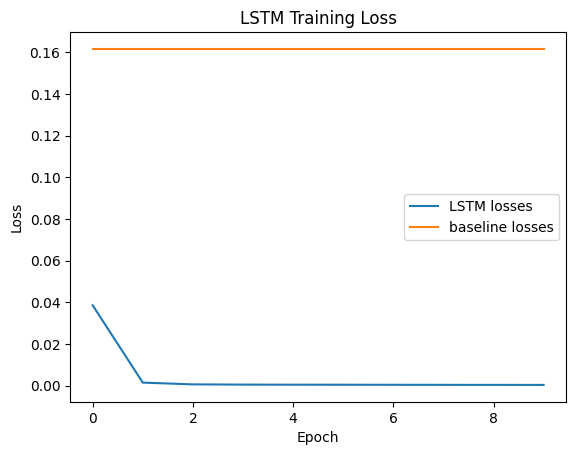

In [11]:
# plotting loss vs baseline loss
plt.plot(losses_lstm,label="LSTM losses")
plt.plot(baseline_loss,label="baseline losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

In [12]:
model_LSTM.eval()

# Testing LSTM and comparing loss with baseline loss
with torch.no_grad():
    test_loss=0.0
    for (inputs, targets) in dataset_test:
        inputs = torch.tensor(inputs,dtype=torch.float32)
        targets = torch.tensor(targets,dtype=torch.float32)
        predicted_sum = model_LSTM(inputs)
        loss = criterian(predicted_sum,targets)
        test_loss += loss.item()
        
    test_loss /= len(dataset_test) 
    print(f'LSTM Test Loss: {test_loss}')


with torch.no_grad():
    test_loss = 0.0
    for (inputs, targets) in dataset_test:
        outputs = modelbase()
        loss = criterian(outputs, torch.tensor(targets,dtype=torch.float32))
        test_loss += loss.item()
        
    test_loss /= len(dataset_test) 
    print(f'Base line Test Loss: {test_loss}')

LSTM Test Loss: 0.00032494403118016633
Base line Test Loss: 0.16553435947762457


### GRU

In [13]:
class GRU(nn.Module):
    def __init__(self):
        super().__init__()

        # defining randomly initialized weights for forget gate
        self.whz = nn.Parameter(torch.rand((5,5)),requires_grad=True)
        self.wxz = nn.Parameter(torch.rand((5,2)),requires_grad=True)
        self.bz = nn.Parameter(torch.rand((5,1)),requires_grad = True)

        # defining randomly initialized weights for read gate
        self.whr = nn.Parameter(torch.rand((5,5)),requires_grad=True)
        self.wxr = nn.Parameter(torch.rand((5,2)),requires_grad=True)
        self.br = nn.Parameter(torch.rand((5,1)),requires_grad = True)

        # defining randomly initialized weights for write state
        self.whh = nn.Parameter(torch.rand((5,5)),requires_grad=True)
        self.wxh = nn.Parameter(torch.rand((5,2)),requires_grad=True)
        self.bh = nn.Parameter(torch.rand((5,1)),requires_grad = True)

        self.v = torch.rand((1,5))
        self.b = torch.rand((1,5))
        self.h = torch.zeros((5,1))

    # defining forward pass
    def forward(self,X):
        copyh = self.h
        for i in range(len(X)):
            zt = torch.sigmoid(torch.matmul(self.whz,copyh)+torch.matmul(self.wxz,X[i])+self.bz)
            rt = torch.sigmoid(torch.matmul(self.whr,copyh)+torch.matmul(self.wxr,X[i])+self.br) 
            ht = torch.tanh(torch.matmul(self.whh,(rt*copyh))+torch.matmul(self.wxh,X[i])+self.bh)
            copyh = (1-zt) * copyh + zt * ht
            
        y = torch.matmul(self.v,copyh) + self.b

        return y

In [14]:
# defining model and optimizer
model_GRU = GRU()
optimizer_GRU = optim.Adam(model_GRU.parameters(),lr=0.001)
model_GRU.train()

# training GRU
losses_GRU = []
for epoch in range(num_epochs):
    tot_loss = 0.0
    for (inputs, targets) in dataset:
        optimizer_GRU.zero_grad()

        outputs = model_GRU(torch.tensor(inputs,dtype=torch.float32))
        targets = torch.tensor(targets,dtype=torch.float32)
        loss = criterian(outputs, targets)

        loss.backward()
        optimizer_GRU.step()

        tot_loss += loss.item()

    losses_GRU.append(tot_loss/len(dataset))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {tot_loss/len(dataset)}')

Epoch [1/10], Loss: 0.37094434988498104
Epoch [2/10], Loss: 0.022427795563812834
Epoch [3/10], Loss: 0.005435359536243595
Epoch [4/10], Loss: 0.002489266733746922
Epoch [5/10], Loss: 0.0013445580236997102
Epoch [6/10], Loss: 0.0007638311994226626
Epoch [7/10], Loss: 0.0004557752816854304
Epoch [8/10], Loss: 0.0002889409963195391
Epoch [9/10], Loss: 0.0002002670231040554
Epoch [10/10], Loss: 0.00015195346894720103


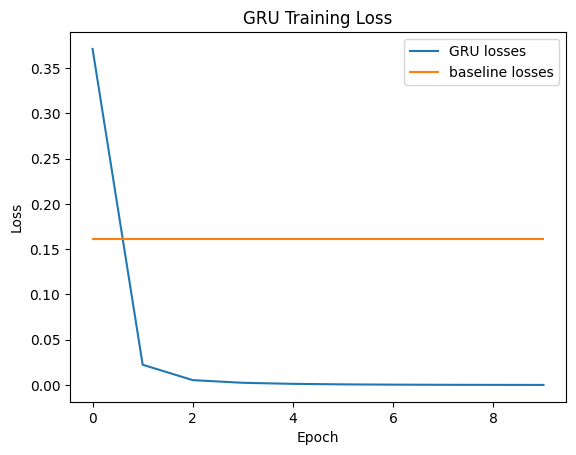

In [15]:
# plotting loss vs baseline loss
plt.plot(losses_GRU,label="GRU losses")
plt.plot(baseline_loss,label="baseline losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training Loss')
plt.show()

In [16]:
model_GRU.eval()

# Testing GRU and comparing loss with baseline loss
with torch.no_grad():
    test_loss=0.0
    for (inputs, targets) in dataset_test:
        inputs = torch.tensor(inputs,dtype=torch.float32)
        targets = torch.tensor(targets,dtype=torch.float32)
        predicted_sum = model_GRU(inputs)
        loss = criterian(predicted_sum,targets)
        test_loss += loss.item()
        
    test_loss /= len(dataset_test) 
    print(f'GRU Test Loss: {test_loss}')


with torch.no_grad():
    test_loss = 0.0
    for (inputs, targets) in dataset_test:
        outputs = modelbase()
        loss = criterian(outputs, torch.tensor(targets,dtype=torch.float32))
        test_loss += loss.item()
        
    test_loss /= len(dataset_test) 
    print(f'Base line Test Loss: {test_loss}')

GRU Test Loss: 0.00048222517593103474
Base line Test Loss: 0.16553435947762457


### Comparision of Elman ,LSTM, and GRU

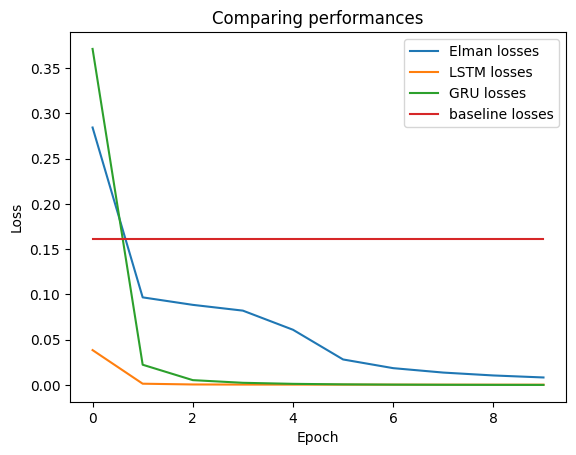

In [17]:
plt.plot(losses_elman,label="Elman losses")
plt.plot(losses_lstm,label="LSTM losses")
plt.plot(losses_GRU,label="GRU losses")
plt.plot(baseline_loss,label="baseline losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparing performances')
plt.show()